In [9]:
import urllib.robotparser
from urllib.parse import urlparse

def is_scraping_allowed(target_url, user_agent='*'):
    """
    Checks if the robots.txt allows scraping for the given URL.
    """
    parsed_url = urlparse(target_url)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    robots_url = f"{base_url}/robots.txt"
    
    rp = urllib.robotparser.RobotFileParser()
    rp.set_url(robots_url)
    
    try:
        rp.read()
        allowed = rp.can_fetch(user_agent, target_url)
        print(f"Checking: {target_url}")
        print(f"Robots.txt URL: {robots_url}")
        print(f"Permission: {'GRANTED' if allowed else 'DENIED'}")
        return allowed
    except Exception as e:
        print(f"Error checking robots.txt: {e}")
        return False

is_scraping_allowed("https://www.jil.go.jp/kokunai/statistics/shuyo/0208.html")



Checking: https://www.jil.go.jp/kokunai/statistics/shuyo/0208.html
Robots.txt URL: https://www.jil.go.jp/robots.txt
Permission: GRANTED


True

# 分析：求人減速の早期警戒シグナル（有効求人倍率・新規求人倍率）

## 目的
### 仮説1：2024年10月〜2025年11月にかけて求人需給は緩和し、特にパートタイムで求人倍率（有効・新規）の低下が大きい  
### 仮説2：新規求人倍率 − 有効求人倍率（新規−有効）のギャップが縮小し、採用の「流入（新規求人）」が弱まっている

## 方法
### SQLite（テーブル：job_offers_jp）から月次データのみ（`月 != '平均'`）をSQLで抽出し、時系列推移・開始 >> 終了の変化量・ギャップ推移を可視化する。


In [23]:

import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import platform  

OUT_DIR = "."
os.makedirs(OUT_DIR, exist_ok=True)

print("準備完了：ライブラリ読み込み")


準備完了：ライブラリ読み込み


## 1. DBからデータ取得（SQL抽出）

### 抽出条件：`月 != '平均'`（年平均を除外して月次のみを取得）  
### 並び順：年・月の昇順（文字列→整数へCAST）


In [12]:
DB_PATH = "data.db"  

sql_monthly = """
SELECT *
FROM job_offers_jp
WHERE 月 != '平均'
ORDER BY CAST(年 AS INT), CAST(月 AS INT);
"""

with sqlite3.connect(DB_PATH) as conn:
    monthly = pd.read_sql_query(sql_monthly, conn)

display(monthly.head())
print("取得行数:", len(monthly))
print("列:", monthly.columns.tolist())


,年,月,有効求人倍率_新卒除き パート含む,有効求人倍率_新卒及び パート除く,有効求人倍率_パートタイム,新規求人倍率_新卒除き パート含む,新規求人倍率_新卒及び パート除く,新規求人倍率_パートタイム
0,2024,10,1.25,1.29,1.20,2.25,2.21,2.33
1,2024,11,1.25,1.28,1.19,2.25,2.24,2.24
2,2024,12,1.25,1.29,1.18,2.27,2.23,2.28
3,2025,1,1.26,1.30,1.18,2.32,2.31,2.30
4,2025,2,1.24,1.29,1.16,2.30,2.32,2.29


取得行数: 14
列: ['年', '月', '有効求人倍率_新卒除き  パート含む', '有効求人倍率_新卒及び  パート除く', '有効求人倍率_パートタイム', '新規求人倍率_新卒除き  パート含む', '新規求人倍率_新卒及び  パート除く', '新規求人倍率_パートタイム']


## 2. 分析用の年月（date列）を作成し、対象期間（開始/終了）を確認


In [13]:
monthly = monthly.copy()
monthly["年_int"] = monthly["年"].astype(int)
monthly["月_int"] = monthly["月"].astype(int)

monthly["date"] = pd.to_datetime(
    monthly["年_int"].astype(str) + "-" + monthly["月_int"].astype(str).str.zfill(2) + "-01"
)

monthly = monthly.sort_values("date").reset_index(drop=True)

start_date = monthly["date"].min()
end_date = monthly["date"].max()

print("月次データの期間（開始）:", start_date.strftime("%Y-%m"))
print("月次データの期間（終了）:", end_date.strftime("%Y-%m"))
display(monthly.tail())


月次データの期間（開始）: 2024-10
月次データの期間（終了）: 2025-11


,年,月,有効求人倍率_新卒除き パート含む,有効求人倍率_新卒及び パート除く,有効求人倍率_パートタイム,新規求人倍率_新卒除き パート含む,新規求人倍率_新卒及び パート除く,新規求人倍率_パートタイム,年_int,月_int,date
9,2025,7,1.22,1.27,1.16,2.17,2.16,2.19,2025,7,2025-07-01
10,2025,8,1.20,1.25,1.14,2.15,2.13,2.15,2025,8,2025-08-01
11,2025,9,1.20,1.25,1.14,2.14,2.12,2.21,2025,9,2025-09-01
12,2025,10,1.18,1.23,1.11,2.12,2.11,2.18,2025,10,2025-10-01
13,2025,11,1.18,1.22,1.11,2.14,2.13,2.08,2025,11,2025-11-01


## 3. 指標（列名）定義：有効求人倍率・新規求人倍率（セグメント別）


In [14]:
active_cols = {
    "全体（新卒除き＋パート含む）": "有効求人倍率_新卒除き  パート含む",
    "正規（新卒・パート除く）": "有効求人倍率_新卒及び  パート除く",
    "パートタイム": "有効求人倍率_パートタイム",
}

new_cols = {
    "全体（新卒除き＋パート含む）": "新規求人倍率_新卒除き  パート含む",
    "正規（新卒・パート除く）": "新規求人倍率_新卒及び  パート除く",
    "パートタイム": "新規求人倍率_パートタイム",
}

print("有効求人倍率（列）:", list(active_cols.values()))
print("新規求人倍率（列）:", list(new_cols.values()))


有効求人倍率（列）: ['有効求人倍率_新卒除き  パート含む', '有効求人倍率_新卒及び  パート除く', '有効求人倍率_パートタイム']
新規求人倍率（列）: ['新規求人倍率_新卒除き  パート含む', '新規求人倍率_新卒及び  パート除く', '新規求人倍率_パートタイム']


## 4. 仮説1の検証：開始→終了の変化量・変化率（有効/新規 × セグメント）

### 仮説1：パートタイムの低下が最も大きい


In [15]:
start_row = monthly.loc[monthly["date"] == start_date].iloc[0]
end_row = monthly.loc[monthly["date"] == end_date].iloc[0]

def change_stats(col_name: str):
    s = float(start_row[col_name])
    e = float(end_row[col_name])
    abs_change = e - s
    pct_change = (e / s - 1.0) * 100.0
    return s, e, abs_change, pct_change

rows = []
for seg, col in active_cols.items():
    s, e, dc, pc = change_stats(col)
    rows.append(["有効求人倍率", seg, s, e, dc, pc])

for seg, col in new_cols.items():
    s, e, dc, pc = change_stats(col)
    rows.append(["新規求人倍率", seg, s, e, dc, pc])

h1_summary = pd.DataFrame(
    rows,
    columns=["指標", "セグメント", "開始", "終了", "変化量（終了-開始）", "変化率（%）"]
)

display(h1_summary)

print("仮説1の判定ポイント：変化率（%）が最もマイナスのセグメント＝低下が最大")


,指標,セグメント,開始,終了,変化量（終了-開始）,変化率（%）
0,有効求人倍率,全体（新卒除き＋パート含む）,1.25,1.18,-0.07,-5.600000
1,有効求人倍率,正規（新卒・パート除く）,1.29,1.22,-0.07,-5.426357
2,有効求人倍率,パートタイム,1.20,1.11,-0.09,-7.500000
3,新規求人倍率,全体（新卒除き＋パート含む）,2.25,2.14,-0.11,-4.888889
4,新規求人倍率,正規（新卒・パート除く）,2.21,2.13,-0.08,-3.619910
5,新規求人倍率,パートタイム,2.33,2.08,-0.25,-10.729614


仮説1の判定ポイント：変化率（%）が最もマイナスのセグメント＝低下が最大


## 5. 仮説2の検証：採用流入ギャップ（新規求人倍率 − 有効求人倍率）

### 仮説2：ギャップが縮小（特にパートで顕著）


In [16]:
gap = monthly[["date"]].copy()

for seg in active_cols.keys():
    gap_col = f"ギャップ（新規-有効）_{seg}"
    gap[gap_col] = monthly[new_cols[seg]] - monthly[active_cols[seg]]

gap_rows = []
for seg in active_cols.keys():
    col = f"ギャップ（新規-有効）_{seg}"
    s = float(gap.loc[gap["date"] == start_date, col].iloc[0])
    e = float(gap.loc[gap["date"] == end_date, col].iloc[0])
    gap_rows.append([seg, s, e, e - s, (e / s - 1.0) * 100.0])

h2_summary = pd.DataFrame(
    gap_rows,
    columns=["セグメント", "開始", "終了", "変化量（終了-開始）", "変化率（%）"]
)

display(h2_summary)

print("仮説2の判定ポイント：ギャップ（新規-有効）が縮小（マイナス）しているか")


,セグメント,開始,終了,変化量（終了-開始）,変化率（%）
0,全体（新卒除き＋パート含む）,1.00,0.96,-0.04,-4.000000
1,正規（新卒・パート除く）,0.92,0.91,-0.01,-1.086957
2,パートタイム,1.13,0.97,-0.16,-14.159292


仮説2の判定ポイント：ギャップ（新規-有効）が縮小（マイナス）しているか


## 6. 可視化（スライド貼り付け用PNGを保存）

### 図1：有効求人倍率（月次）セグメント別推移  
###  図2：新規求人倍率（月次）セグメント別推移  
### 図3：採用流入ギャップ（新規−有効）の推移  


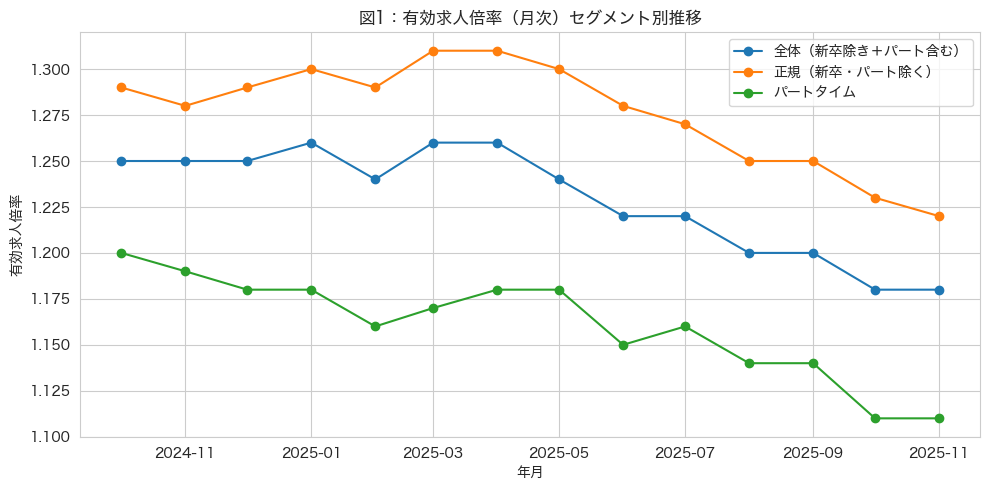

保存先: ./図1_有効求人倍率_月次_セグメント別推移.png


In [27]:


system = platform.system()
if system == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'Hiragino Sans'
else: 
    plt.rcParams['font.family'] = 'Noto Sans CJK JP'
    

fig1_path = os.path.join(OUT_DIR, "図1_有効求人倍率_月次_セグメント別推移.png")

plt.figure(figsize=(10, 5))
for seg, col in active_cols.items():
    plt.plot(monthly["date"], monthly[col], marker="o", label=seg)

plt.title("図1：有効求人倍率（月次）セグメント別推移")
plt.xlabel("年月")
plt.ylabel("有効求人倍率")
plt.legend()
plt.tight_layout()
plt.savefig(fig1_path, dpi=200)
plt.show()

print("保存先:", fig1_path)

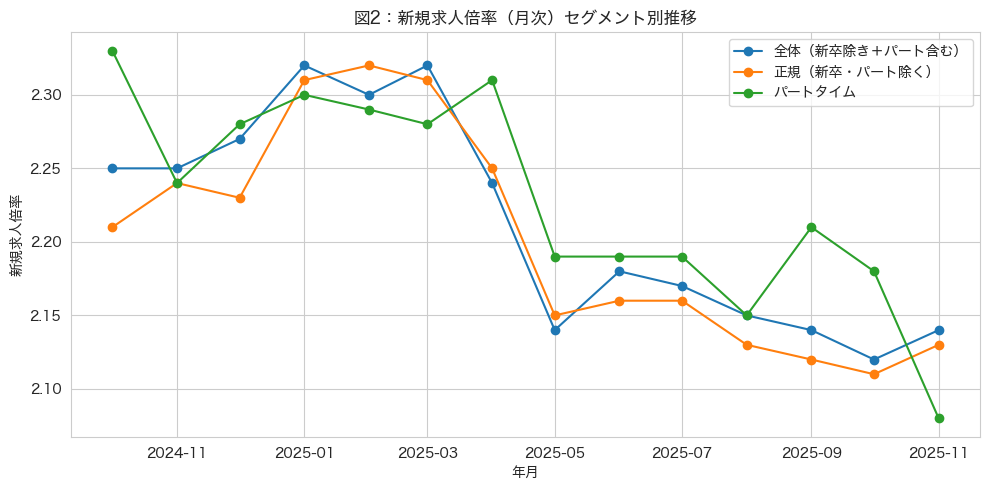

保存先: ./図2_新規求人倍率_月次_セグメント別推移.png


In [26]:


system = platform.system()
if system == 'Darwin':  
    plt.rcParams['font.family'] = 'Hiragino Sans'
else: 
    plt.rcParams['font.family'] = 'Noto Sans CJK JP'
fig2_path = os.path.join(OUT_DIR, "図2_新規求人倍率_月次_セグメント別推移.png")

plt.figure(figsize=(10, 5))
for seg, col in new_cols.items():
    plt.plot(monthly["date"], monthly[col], marker="o", label=seg)

plt.title("図2：新規求人倍率（月次）セグメント別推移")
plt.xlabel("年月")
plt.ylabel("新規求人倍率")
plt.legend()
plt.tight_layout()
plt.savefig(fig2_path, dpi=200)
plt.show()

print("保存先:", fig2_path)


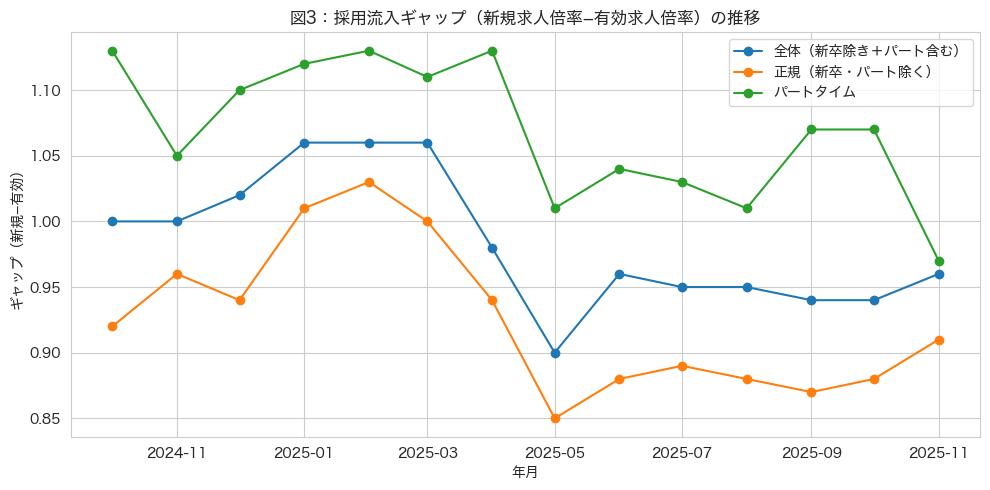

保存先: ./図3_採用流入ギャップ_新規-有効_推移.png


In [29]:
fig3_path = os.path.join(OUT_DIR, "図3_採用流入ギャップ_新規-有効_推移.png")

plt.figure(figsize=(10, 5))
for seg in active_cols.keys():
    col = f"ギャップ（新規-有効）_{seg}"
    plt.plot(gap["date"], gap[col], marker="o", label=seg)

plt.title("図3：採用流入ギャップ（新規求人倍率−有効求人倍率）の推移")
plt.xlabel("年月")
plt.ylabel("ギャップ（新規−有効）")
plt.legend()
plt.tight_layout()
plt.savefig(fig3_path, dpi=200)
plt.show()

print("保存先:", fig3_path)


## 7. 結論（ノートブック用メモ）

### 仮説1：パートタイムの求人倍率（有効・新規）の低下が相対的に大きい  
### 仮説2：ギャップ（新規−有効）が縮小し、採用の流入が弱まっている（特にパートで顕著）
